This notebook demonstrates use of SARIMAX and Box-Jenkins approach using energy consumption dataset

Slightly modified from a previous version shared by Tomasz Wiktorski

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from statsmodels.tsa.statespace import sarimax
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

Data can be downloaded from:
http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

In [2]:
energy_cons = pd.read_csv('../power-cons/household_power_consumption.txt', sep=';', 
                          parse_dates={'Date_time': ['Date', 'Time']}, infer_datetime_format=True, 
                          na_values=['?'], index_col='Date_time').resample('D').mean()

<AxesSubplot:xlabel='Date_time'>

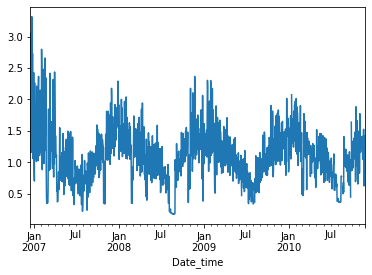

In [3]:
data = energy_cons['Global_active_power']
data.plot()

## The ARIMA model
ARIMA is, arguably, the most common methods for modeling of time series. The ARIMA model can be used for analysis or prediction of a time series. The model is usually represented as ARIMA(p, d, q).

AR stands for autoregressive process, which models time series as linear combination of lagged time series values. The term *p* specifies the number of lagged time series values to include.  

MA stands for moving average process, which models time series as linear combination of lagged errors at the respective time lags of the series. The term *q* specifies the number of lagged error values to include.

I stands for integrated process, which accounts for non-stationarity of the modeled time series. It is achieved by differencing the original time series before modeling. As a consequence the final model needs to be integrated, hence the name. The term *d* specifies the order of differencing/integration.

## The Box-Jenkins method
Is a standardized approach to time series modelling using ARIMA model. It consists of a set of data preparation and modeling steps, the number and content of steps changed with time. A common version, based on [Hyndman](https://robjhyndman.com/papers/BoxJenkins.pdf) has five steps:
1. Data preparation, consists of applying various transformation with focus on obtaining stationary time series;
2. Model selection, indentifies ARIMA processes based on various graphs (usually ACF and PACF);
3. Parameter estimation, finds model coeffients using computational algorithms;
4. Model checking, tests the model and repeats steps 2-3 to find a better one;
5. Forecasting, uses model to predict future values.

## The SARIMAX model
Time series can have seasonal variations that result in changes in value that are difficult to capture with three basic ARIMA processes. Seasonal ARIMA model adds additional lagged terms related to seasonal variations. Seasonal variation can be spotted on ACF and PACF, but often it can also be based on background knowledge or clearly noticable in raw data.

(S)ARIMA model assumes that data a particular variable can be modeled by the linear combination of its lagged values and errors. While such models can be applied with success to many problems, we might encounter situations where there is a need to include additional variables that contribute to the model. Such variables are usually called *exogeneous*. Such variable is the used as a form of adjustment for the current time series value.

SARIMAX model is the one we will futher apply to energy consuption prediction.


In [4]:
train = energy_cons['Global_active_power']['2008-07-01':'2009-06-30'].fillna(method='bfill')
test = energy_cons['Global_active_power']['2009-07-01':'2010-06-30'].fillna(method='bfill')

<AxesSubplot:xlabel='Date_time'>

<AxesSubplot:xlabel='Date_time'>

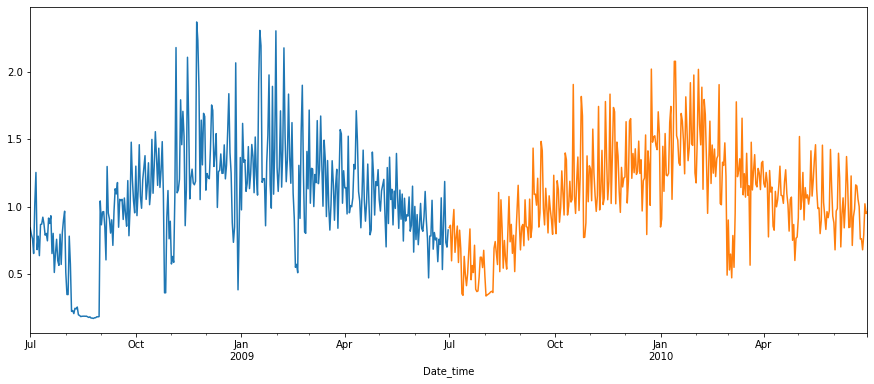

In [5]:
train.plot(figsize=(15, 6))
test.plot()

For time series to be stationary its statistical properites must not depend on time. The properties we most often use are: mean, variance, covariance. Mean is simply an average value of time series over a period of time. Variance describes how much time series deviates from that mean over time. Covariance (with lagged values) describes how fast the variation from the mean is.

Stationarity is a condition for successful ARMA modelling. In particular, regression used to derive ARMA parameters asssumes independence between variables (time series observations). Most of the statistical properties that hold for independent variables hold also for stationary variables.

We can test for stationarity to either by ploting the time series with its statistics and observing changes over time. Alternatively we can apply augmented Dickey–Fuller test. The result of the test is a negative number that describes how strongly the stationarity hypothesis is rejected. The lower number is the better. 

A typical way to achieve stationarity in ARIMA modelling is by taking first difference of data. It is also possible to further difference by e.g. subtracking trend.

<AxesSubplot:xlabel='Date_time'>

<AxesSubplot:xlabel='Date_time'>

<AxesSubplot:xlabel='Date_time'>

-2.439718826244116

0.13083834833462604

{'1%': -3.44880082033912, '5%': -2.869670179576637, '10%': -2.5711012838861036}

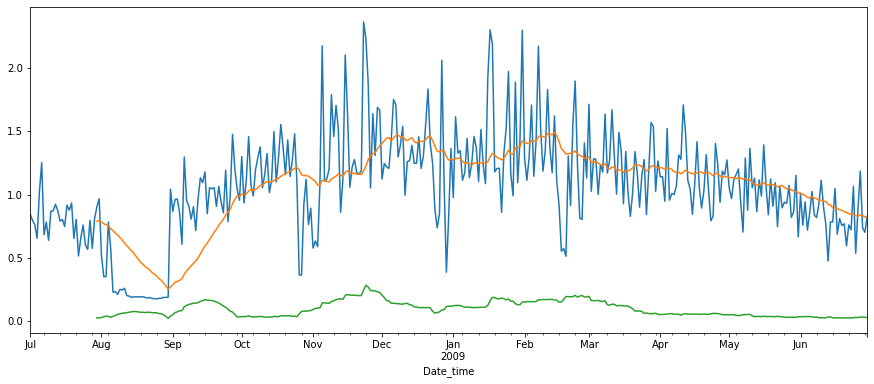

In [6]:
train.plot(figsize=(15,6))
train.rolling(30).mean().plot()
train.rolling(30).var().plot()
adfuller(train)[0]
adfuller(train)[1]
adfuller(train)[4]

<AxesSubplot:xlabel='Date_time'>

<AxesSubplot:xlabel='Date_time'>

<AxesSubplot:xlabel='Date_time'>

-14.172424641481168

1.9925566377756824e-26

{'1%': -3.448748905151901,
 '5%': -2.8696473721448728,
 '10%': -2.5710891239349585}

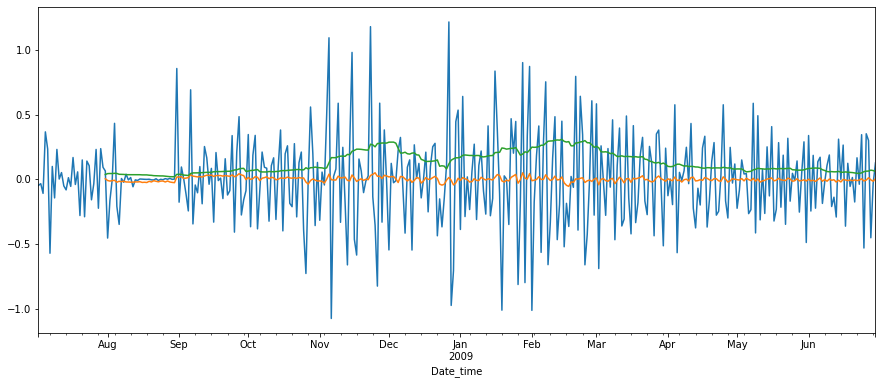

In [7]:
train_1d = (train-train.shift(1)).dropna()
train_1d.plot(figsize=(15,6))
train_1d.rolling(30).mean().plot()
train_1d.rolling(30).var().plot()
adfuller(train_1d)[0]
adfuller(train_1d)[1]
adfuller(train_1d)[4]

<AxesSubplot:xlabel='Date_time'>

<AxesSubplot:xlabel='Date_time'>

<AxesSubplot:xlabel='Date_time'>

-10.956923421227211

8.51600729192414e-20

{'1%': -3.4493918438232525,
 '5%': -2.8699298018856574,
 '10%': -2.5712397066390458}

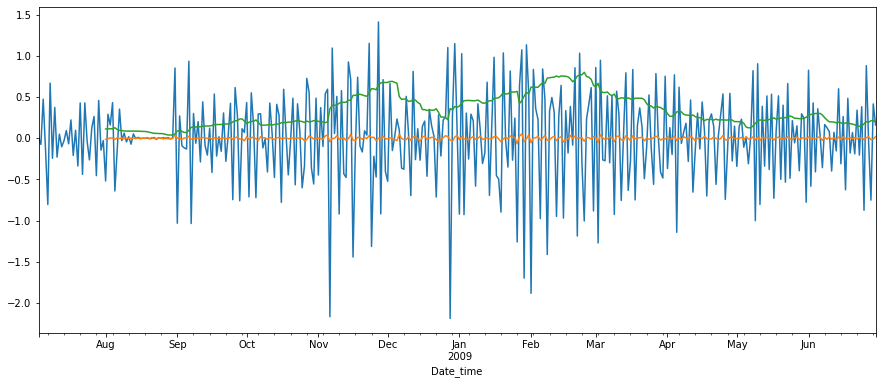

In [8]:
train_2d = (train_1d-train_1d.shift(1)).dropna()
train_2d.plot(figsize=(15,6))
train_2d.rolling(30).mean().plot()
train_2d.rolling(30).var().plot()
adfuller(train_2d)[0]
adfuller(train_2d)[1]
adfuller(train_2d)[4]

## Identifying AR and MA processes

To identify AR and MA processes, we will use autocorrelation and partial autocorrelation plots based on the differenced time series.

Autocorrelation function (ACF) is a correlation of the series with a lagged copy of itself as a function of the lag. It describes how an observation at an particular time point relates to observations at the preceeding time points.

Partial autocorrelation function (PACF) is a correlation of the series with a lagged copy of itself as a function of the lag **when correlation from all other lags is removed**.

In Box-Jenkins method PACF is used to identify AR process with its order and ACF to identify MA process with its order. You can find more details at [Duke's statistical forecasting website](https://people.duke.edu/~rnau/411arim3.htm).

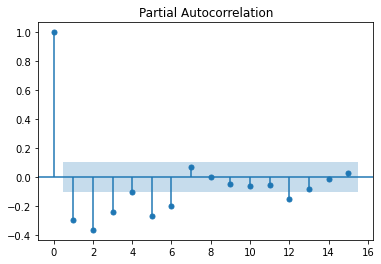

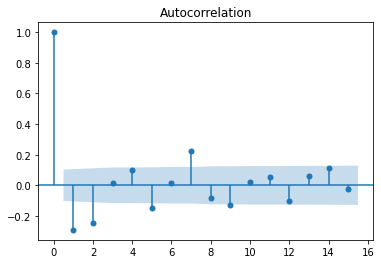

In [9]:
pacf = plot_pacf(train_1d, lags=15)
acf = plot_acf(train_1d, lags=15)

Based on PACF graph AR process might be present with order 1. However, no AR process at all could also be considered.

Based on ACF graph MA proces is present with order 1. However, order 3 could also be considered.

We also know from stationarity testing that we need integration with order 1.

In [10]:
sarimax_model = sarimax.SARIMAX(train,
                        order=(1,1,1), 
                        seasonal_order=(1, 1, 1, 7)).fit()

forecast = sarimax_model.predict(365, 729)

<AxesSubplot:xlabel='Date_time'>

<AxesSubplot:xlabel='Date_time'>

0.16385234867054352

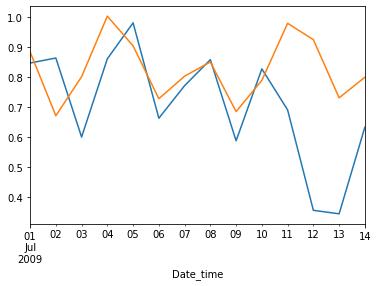

In [11]:
test[:14].plot()
forecast[:14].plot()
mean_absolute_error(test[:14], forecast[:14])

<AxesSubplot:xlabel='Date_time'>

<AxesSubplot:xlabel='Date_time'>

0.3648011790534194

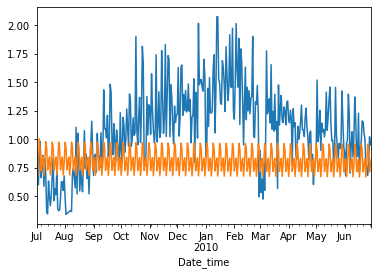

In [12]:
test.plot()
forecast.plot()
mean_absolute_error(test, forecast)

## Seasonal decompostion
Seasonal decomposition is a method to divide a time series into 3 components: trend, seasonal variation, and residual.

There is a basic implementation of this method available in stats models, which uses moving averages to obtain the 3 components from the time series.

It can be used as an alternative way to assess stationarity. We will on the other hand is the trend elements element of decomposition as an exogenous variable in our model.

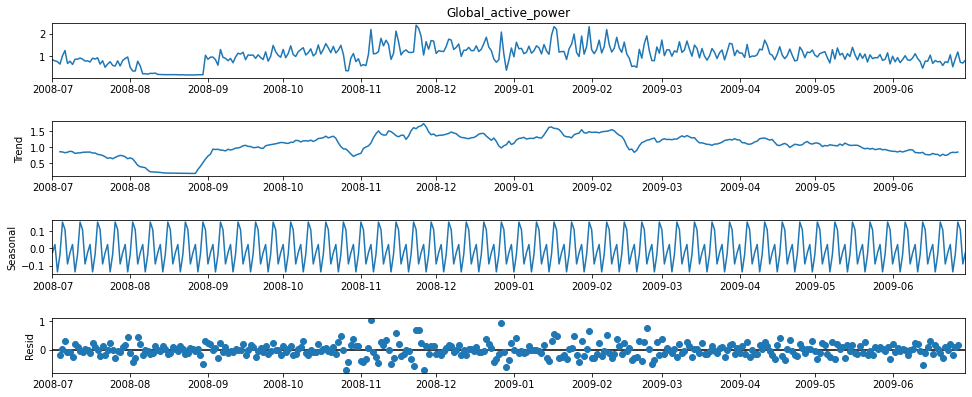

In [13]:
sdt = seasonal_decompose(train).plot()
sdt.set_size_inches(15,6)

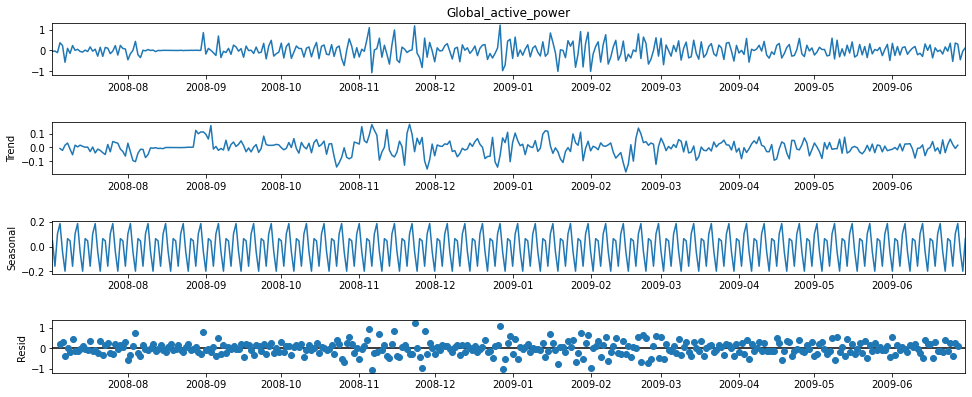

In [14]:
sdt = seasonal_decompose(train_1d).plot()
sdt.set_size_inches(15,6)

## Final SARIMAX model

In [15]:
train_exog = seasonal_decompose(train).trend.fillna(method='bfill').fillna(method='ffill')
sarimax_model = sarimax.SARIMAX(train,
                        order=(1,1,1), 
                        seasonal_order=(1, 1, 1, 7),
                        exog=pd.DataFrame(train_exog)).fit()

test_exog = seasonal_decompose(test).trend.fillna(method='bfill').fillna(method='ffill')
forecast = sarimax_model.predict(365, 729, exog=pd.DataFrame(test_exog))

<AxesSubplot:xlabel='Date_time'>

<AxesSubplot:xlabel='Date_time'>

0.11687581604873216

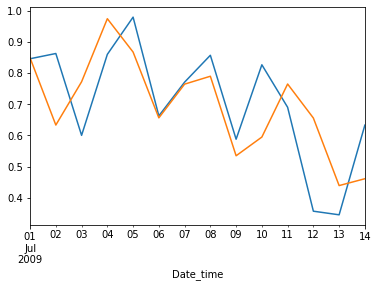

In [16]:
test[:14].plot()
forecast[:14].plot()
mean_absolute_error(test[:14], forecast[:14])

<AxesSubplot:xlabel='Date_time'>

<AxesSubplot:xlabel='Date_time'>

0.1502825348937291

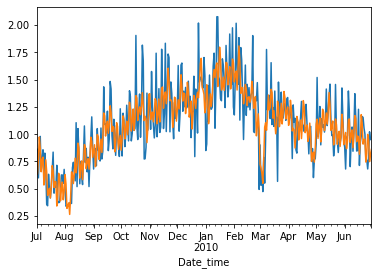

In [17]:
test.plot()
forecast.plot()
mean_absolute_error(test, forecast)